# Linear dynamical system, Gaussian observations

In this demo notebook, we show how to use SING for inference in a linear dynamical system with Gaussian observations. While the standard approach for inference in a linear Gaussian model is Kalman smoothing, here we demonstrate that SING also performs inference in a single step.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import vmap
from jax import random as jr

from functools import partial
import matplotlib.pyplot as plt

In [3]:
# Check that we are on GPU
print(jax.devices())

[CudaDevice(id=0)]


## Generate ground truth system and observations

First, we'll generate a synthetic linear dynamical system with linear Gaussian observations. The latent SDE is parametrized as, $$d\boldsymbol{x}(t) = (\boldsymbol{A} \boldsymbol{x}(t) + \boldsymbol{b}) dt + \boldsymbol{\Sigma}^{1/2}d\boldsymbol{w}(t),$$ i.e. the drift function is linear. Here, we generate a system with 2D latent dynamics consisting of a counter-clockwise rotation, and from there generate 10D Gaussian observations at each time step according to the observation model $$\boldsymbol{y}(t) \sim \mathcal{N}(\boldsymbol{C} \boldsymbol{x}(t) + \boldsymbol{d}, \boldsymbol{R}).$$ We will generate 30 independent trials from randomly sampled initial conditions.

In [4]:
# Parameters
key = jr.PRNGKey(12)
latent_dim = 2
obs_dim = 10

t_max = 1.
n_timesteps = 1000
n_trials = 30
dt = t_max / n_timesteps

In [5]:
from sing.sde import LinearSDE
from sing.simulate_data import simulate_sde, simulate_gaussian_obs

# Initialize the true (linear) SDE
theta = jnp.pi / 250.
rot_scale = 0.997
rot_mat = rot_scale * jnp.array([[jnp.cos(theta), -jnp.sin(theta)],[jnp.sin(theta), jnp.cos(theta)]])
drift_params_true = {
    'A': (rot_mat - jnp.eye(latent_dim)) / dt, # convert from discrete to continuous time dynamics
    'b': jnp.zeros((latent_dim,))
}
linear_sde = LinearSDE(latent_dim=latent_dim)
drift_fn = lambda x, t: linear_sde.drift(drift_params_true, x, t)

# Simulate true latents from SDE
key, key_x0, *keys_xs = jr.split(key, n_trials + 2)
x0s = jr.uniform(key_x0, (n_trials, latent_dim), minval=-2., maxval=2.)
xs = vmap(partial(simulate_sde, f=drift_fn, t_max=t_max, n_timesteps=n_timesteps))(jnp.array(keys_xs), x0s)

# Simulate Gaussian observations
key, *keys_ys = jr.split(key, n_trials + 1)
key_C, key_d, key_R = jr.split(key, 3)
output_params_true = {
    'C': jr.normal(key_C, (obs_dim, latent_dim)),
    'd': jr.normal(key_d, (obs_dim,)),
    'R': 0.1 * jnp.ones((obs_dim,))
}
ys = vmap(partial(simulate_gaussian_obs, output_params=output_params_true))(jnp.array(keys_ys), xs)

Plot ground-truth dynamics with 2 example trials:

Text(0.5, 0.98, 'True latents & dynamics')

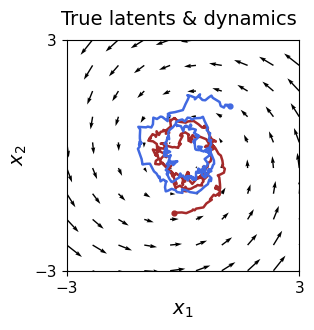

In [6]:
from sing.plotting import plot_dynamics_and_latents_2d

# Set font and label size for all plots
fontsize = 14
labelsize = 11

# Plot true latents and dynamics
dynamics_fn = lambda x: drift_params_true['A'] @ x + drift_params_true['b']

fig, ax = plt.subplots(figsize=(3, 3))
ax = plot_dynamics_and_latents_2d(dynamics_fn, xlim=(-3, 3), ylim=(-3, 3), n_xpts=10, n_ypts=10, ax=ax)

trials_to_plot = [0, 6]
colors = ['brown', 'royalblue']
skip = 4
for i, idx in enumerate(trials_to_plot):
    ax.plot(xs[idx,::skip,0], xs[idx,::skip,1], lw=1.8, color=colors[i])
    ax.scatter(xs[idx,0,0], xs[idx,0,1], s=12, color=colors[i])
ax.set_xticks([-3, 3])
ax.set_yticks([-3, 3])
ax.set_xlabel(r'$x_1$', fontsize=fontsize)
ax.set_ylabel(r'$x_2$', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)

fig.suptitle('True latents & dynamics', fontsize=fontsize)

Text(0.5, 0.98, 'Observations')

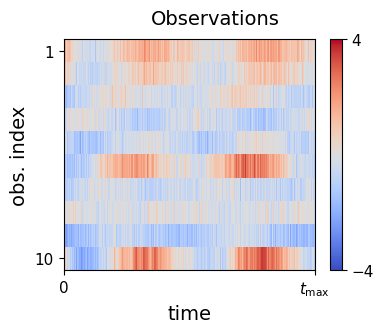

In [7]:
# Plot observations on an example trial
fig, ax = plt.subplots(figsize=(4.05, 3))

trial_idx = 0
im = ax.imshow(ys[trial_idx].T, aspect='auto', extent=(0, t_max, obs_dim+0.5, 0.5), cmap='coolwarm', vmin=-4, vmax=4, interpolation='none')
ax.set_xticks([0, t_max])
ax.set_xticklabels([0, r"$t_{\text{max}}$"])
ax.set_xlabel(r'time', fontsize=fontsize)
ax.set_yticks([1, obs_dim])
ax.set_ylabel(r'obs. index', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)

cbar = fig.colorbar(im, ax=ax)
cbar.set_ticks([-4, 4])
cbar.ax.tick_params(labelsize=labelsize)

fig.suptitle('Observations', fontsize=fontsize)

## Fit SING!
Let's fit a SING model to this data! We will fix model hyperparameters to their true generative models and focus on performing inference over the latent states. 

We'll first initialize the model. This consists of
- Creating `t_grid`, the time grid corresponding to observations or points at which to discretize inference
- Creating a `likelihood` object (in this case Gaussian) with corresponding `t_mask` indicating which time bins have observations
- Initialize a `fn` object with deterministic drift, in this case a `LinearSDE`
- Initialize the mean and covariance of $p(x_0)$

In [8]:
from sing.likelihoods import Gaussian
from sing.sde import LinearSDE

# Likelihood model
t_grid = jnp.linspace(0, t_max, n_timesteps)
t_mask = jnp.ones((n_trials, n_timesteps))
likelihood = Gaussian(ys, t_mask)

# Initalize LinearSDE
fn = LinearSDE(latent_dim=latent_dim)

# Initialize the prior mean and cov
init_params = {
    'mu0': jnp.zeros((n_trials, latent_dim)),
    'V0': jnp.eye(latent_dim)[None].repeat(n_trials, 0)
}

Now we are ready to fit the model. We will simply run one vEM iteration with one SING step (e-step) and show that SING can recover the true latent states. Note that `perform_m_step = False` to indicate that we are only performing inference, not hyperparameter learning. 

In [9]:
from sing.sing import fit_variational_em
key = jr.PRNGKey(1)
n_iters = 1
n_iters_e = 1
rho_sched = jnp.ones(n_iters)

results_sing = fit_variational_em(key, 
                                  fn, 
                                  likelihood, 
                                  t_grid, 
                                  drift_params_true, 
                                  init_params, 
                                  output_params_true, 
                                  batch_size=None, 
                                  rho_sched=rho_sched, 
                                  n_iters=n_iters, 
                                  n_iters_e=n_iters_e,
                                  perform_m_step=False)

Initializing params...
Performing variational EM algorithm...
Iteration 1 / 1, ELBO: -88602.04014453878, ell: -80755.58264743455, KL: 7846.457497104231, prior: 0.0


In [10]:
# Unpack results
marginal_params, natural_params, gp_post, drift_params, init_params, output_params, input_effect, elbos = results_sing
ms_final, Ss_final, _ = marginal_params

Plot inferred latents together with the ground truth (for a single trial):

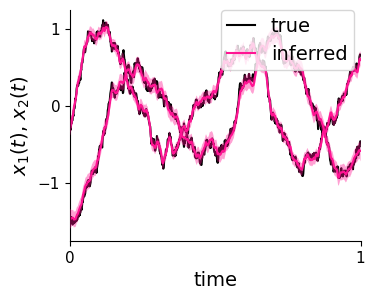

In [11]:
# Plot latents recovery
trial_idx = 0

fig, ax = plt.subplots(figsize=(3.75, 3))
for i in range(latent_dim):
    label1 = "true" if i == 0 else None
    label2 = "inferred" if i == 0 else None
    ax.plot(t_grid, xs[trial_idx,:,i], color='black', zorder=1, label=label1)
    ax.plot(t_grid, ms_final[trial_idx,:,i], color='deeppink', zorder=2, label=label2)
    ax.fill_between(t_grid, ms_final[trial_idx,:,i]+2*jnp.sqrt(Ss_final[trial_idx,:,i,i]),
                    ms_final[trial_idx,:,i]-2*jnp.sqrt(Ss_final[trial_idx,:,i,i]), facecolor='deeppink', alpha=0.4, zorder=3)

ax.set_xlim(0, t_max)
ax.set_xticks([0, t_max])
ax.set_xlabel(r'time', fontsize=fontsize)
ax.locator_params(axis='y', nbins=2)
ax.set_ylabel(r'$x_1(t)$, $x_2(t)$', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.spines[['right', 'top']].set_visible(False)

ax.legend(loc='upper right', bbox_to_anchor=(1.01, 1.04), fontsize=fontsize, borderpad=0.32, handlelength=1.45)